In [341]:
#importing libraries
import numpy as np
import pyspiel
import math
import matplotlib.pyplot as plt
import torch
import copy
from statistics import mean
from torch.distributions import Categorical

from open_spiel.python.algorithms.alpha_zero import model as model_lib
from open_spiel.python.algorithms.alpha_zero import evaluator as evaluator_lib
from open_spiel.python.algorithms import mcts

In [418]:
# build the tensorflow model
def build_model(game, model_type):
    return model_lib.Model.build_model(
      model_type, game.observation_tensor_shape(), game.num_distinct_actions(),
      nn_width=128, nn_depth=4, weight_decay=1e-5, learning_rate=5e-5, path='../../model_saves/connect_four')

In [385]:
def executeEpisode(game, temperature):
    UCT_C = math.sqrt(2)
    rng = np.random.RandomState(42)
    train_inputs = []
    state = game.new_initial_state()
    
    mcts_bot = mcts.MCTSBot(
      game,
      UCT_C,
      max_simulations=100,
      solve=True,
      random_state=rng,
      evaluator=evaluator_lib.AlphaZeroEvaluator(game, model_current_best))
    
    observations = []
    action_masks = []
    policies = []
        
    while not state.is_terminal():
        root = mcts_bot.mcts_search(state)
        policy = np.zeros(game.num_distinct_actions())
        
        for c in root.children:
            policy[c.action] = c.explore_count
        policy = policy ** (1 / temperature)
        policy /= policy.sum()
        action = np.random.choice(len(policy), p=policy)
        obs = state.observation_tensor()
        act_mask = state.legal_actions_mask()
        
        observations.append(obs)
        action_masks.append(act_mask)
        policies.append(policy)
    
        # train_inputs.append(model_lib.TrainInput(obs, act_mask, policy, value=1))              
   
        state.apply_action(action) 
    
    final_game_reward = state.player_reward(0)
    train_inputs = [model_lib.TrainInput(obs, act_mask, policy, value=final_game_reward) for obs, act_mask, policy in zip(observations, action_masks, policies)]
    
    return train_inputs

# 1 Train agent

In [417]:
print_every = 10
n_selfplay_simulations = 25            # How many play throughs should be generated by best model for training. (Training set size)
n_train_steps = 20                     # After how many gradient updates the new model tries to beat the current best
n_iterations = 10                      # How often the whole procedure is repeated. Also corresponds to the number of evaluations
n_evaluations = 11                     # How many games should be played to measure which model is better
minimal_loss_delta = 0.5
batch_size = 16
evaluation_strategy = 'mcts'           # 'best_response'
n_most_recent_train_samples = 50000    # Among which training samples to choose to train current model

In [376]:
game = pyspiel.load_game("connect_four")
model = build_model(game, 'mlp')
print("Num variables:", model.num_trainable_variables)
model.print_trainable_variables()

Num variables: 29448
torso_0_dense/kernel:0: (126, 64)
torso_0_dense/bias:0: (64,)
torso_1_dense/kernel:0: (64, 64)
torso_1_dense/bias:0: (64,)
torso_2_dense/kernel:0: (64, 64)
torso_2_dense/bias:0: (64,)
torso_3_dense/kernel:0: (64, 64)
torso_3_dense/bias:0: (64,)
policy_dense/kernel:0: (64, 64)
policy_dense/bias:0: (64,)
policy/kernel:0: (64, 7)
policy/bias:0: (7,)
value_dense/kernel:0: (64, 64)
value_dense/bias:0: (64,)
value/kernel:0: (64, 1)
value/bias:0: (1,)


In [377]:
model_current_best = copy_and_create_checkpoint(0)

INFO:tensorflow:Restoring parameters from ../../model_saves/connect_four/checkpoint-0


In [408]:
def compute_mcts_policy(root, temperature):
    policy = np.zeros(game.num_distinct_actions())
        
    for c in root.children:
        policy[c.action] = c.explore_count
    if temperature == 0 or temperature is None:
        # Create probability distribution with peak at most likely action
        new_policy = np.zeros(game.num_distinct_actions())
        new_policy[policy.argmax(-1)] = 1
        policy = new_policy
    else:
        policy = policy ** (1 / temperature)
        policy /= policy.sum()
    return policy

In [423]:
def generate_training_data():
    train_inputs = []
    for _ in range(n_selfplay_simulations):
        train_inputs.extend(executeEpisode(game, 1))
    print(f'  - Generated {len(train_inputs)} additional training samples')
    return train_inputs

In [380]:
def mean_total_loss(losses):
    return mean([loss.total for loss in losses])

In [390]:
def train_model(train_inputs):
    losses = []   
    for _ in range(n_train_): 
        train_set_idx = np.random.choice(range(len(train_inputs)), batch_size)
        loss = model.update([train_inputs[i] for i in train_set_idx])
        losses.append(loss)
    print(f'  - Training: {mean_total_loss(losses[:int(len(losses)/4)]):.2f} \
                -> {mean_total_loss(losses[int(len(losses)/4):int(2 * len(losses)/4)]):.2f} \
                -> {mean_total_loss(losses[int(2 * len(losses)/4):int(3 * len(losses)/4)]):.2f} \
                -> {mean_total_loss(losses[int(3 * len(losses)/4):]):.2f}')
    

In [420]:
def evaluate_challenger_model():
    rng = np.random.RandomState(42)
    UCT_C = math.sqrt(2)
    
    if evaluation_strategy == 'mcts':
    
        mcts_bot_best_model = mcts.MCTSBot(
          game,
          UCT_C,
          max_simulations=100,
          solve=True,
          random_state=rng,
          evaluator=evaluator_lib.AlphaZeroEvaluator(game, model_current_best))

        mcts_bot_challenger = mcts.MCTSBot(
          game,
          UCT_C,
          max_simulations=100,
          solve=True,
          random_state=rng,
          evaluator=evaluator_lib.AlphaZeroEvaluator(game, model))
    
    challenger_results = []
    for _ in range(n_evaluations):
        model_challenger_player = np.random.choice([0, 1]) # ensure that each model will play as each player
        state = game.new_initial_state()
        while not state.is_terminal():
            model_current_turn = model if state.current_player() == model_challenger_player else model_current_best
            
            if evaluation_strategy == 'mcts':
                mcts_bot_current_turn = mcts_bot_challenger if state.current_player() == model_challenger_player else mcts_bot_best_model
                root = mcts_bot_current_turn.mcts_search(state)
                policy = compute_mcts_policy(root, 0) # Always choose action with highest visit count
            else:
                pass
                # obs = state.observation_tensor()
                # act_mask = state.legal_actions_mask()
                # value, policy = model_current_turn.inference([obs], [act_mask])
                # TODO: implement
            action = policy.argmax(-1)
            state.apply_action(action)
        challenger_reward = state.player_reward(model_challenger_player)
        challenger_results.append(challenger_reward)
    
    n_challenger_wins = (np.array(challenger_results) == 1).sum()
    challenger_win_rate = n_challenger_wins / n_evaluations
    print(f'  - Challenger won {n_challenger_wins}/{n_evaluations} games ({challenger_win_rate:.2%} win rate)')
    return challenger_win_rate


In [421]:
def copy_and_create_checkpoint(iteration):
    # Generate checkpoint
    model.save_checkpoint(iteration)
    new_model = build_model(game, 'mlp')
    new_model.load_checkpoint(f"{model._path}/checkpoint-{iteration}")
    return new_model

In [422]:
train_inputs = []
for iteration in range(n_iterations):
    print(f"Iteration {iteration}")
    # 1 Generate training data with current best model
    train_inputs.extend(generate_training_data())
    train_inputs = train_inputs[-n_most_recent_train_samples:]
    
    # 2 Repeatedly sample from training set and update weights on current model
    train_model(train_inputs)
    
    # 3 Evaluate trained model against current best model
    challenger_win_rate = evaluate_challenger_model()
    if challenger_win_rate > 0.55:
        print(f"  - Model at iteration {iteration} supersedes previous model ({challenger_win_rate:.2%} win rate)")
        model_current_best = copy_and_create_checkpoint(iteration)
    

Iteration 0
  - Generated 69 training samples
  - Training: 2.98                 -> 3.01                 -> 3.03                 -> 3.00
  - Challenger won 7/11 games (63.64% win rate)
Model at iteration 0 supersedes previous model (63.64% win rate)
INFO:tensorflow:Restoring parameters from ../../model_saves/connect_four/checkpoint-0
Iteration 1
  - Generated 76 training samples
  - Training: 2.88                 -> 2.88                 -> 2.86                 -> 2.85
  - Challenger won 4/11 games (36.36% win rate)
Iteration 2
  - Generated 59 training samples
  - Training: 2.90                 -> 2.87                 -> 2.90                 -> 2.87
  - Challenger won 4/11 games (36.36% win rate)
Iteration 3
  - Generated 60 training samples
  - Training: 2.86                 -> 2.88                 -> 2.82                 -> 2.89
  - Challenger won 4/11 games (36.36% win rate)
Iteration 4
  - Generated 59 training samples
  - Training: 2.88                 -> 2.84                 -> 2

In [156]:
losses = []
all_train_inputs = []
n_updates_until_convergence = []
for i in range(n_playthroughs):
    train_inputs = executeEpisode(game, 1)
    all_train_inputs.append(train_inputs)
    minimal_train_loss = calculate_min_loss(train_inputs)
    loss = None
    n_updates = 0
    while loss is None or loss.total > minimal_train_loss + minimal_loss_delta:
        loss = model.update(train_inputs)
        losses.append(loss)
        n_updates += 1
    n_updates_until_convergence.append(n_updates)
    if (i+1) % print_every == 0:
        print(i + 1, loss)

# 2 Visualization

In [233]:
baseline_losses = [(train_input.value - 0.5) ** 2 - torch.tensor(train_input.policy) @ (torch.ones(game.num_distinct_actions(), dtype=torch.float64) / sum(train_input.legals_mask)).log() 
                   for train_input in train_inputs]
baseline_losses = torch.stack(baseline_losses)

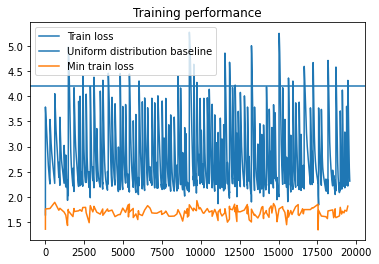

In [189]:
min_loss_iterations = []
for i in range(len(all_train_inputs)):
    min_loss_iterations.append(sum(n_updates_until_convergence[:i]))

plt.title('Training performance')
plt.plot([l.total for l in losses], label='Train loss')
plt.axhline(baseline_losses.mean().item(), label='Uniform distribution baseline')
plt.plot(min_loss_iterations, [calculate_min_loss(train_samples) for train_samples in all_train_inputs], label='Min train loss')
plt.legend()
plt.show()

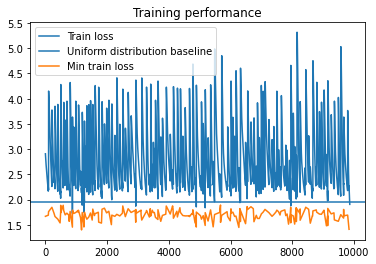

In [234]:
min_loss_iterations = []
for i in range(len(all_train_inputs)):
    min_loss_iterations.append(sum(n_updates_until_convergence[:i]))

plt.title('Training performance')
plt.plot([l.total for l in losses], label='Train loss')
plt.axhline(baseline_losses.mean().item(), label='Uniform distribution baseline')
plt.plot(min_loss_iterations, [calculate_min_loss(train_samples) for train_samples in all_train_inputs], label='Min train loss')
plt.legend()
plt.show()

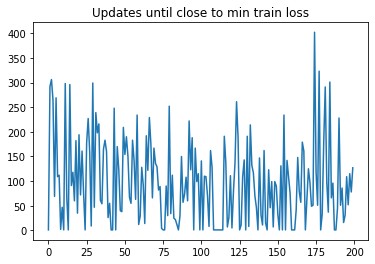

In [194]:
plt.title('Updates until close to min train loss')
plt.plot(n_updates_until_convergence)
plt.show()

# 3 Let learned agent play

In [268]:
only_best_action = True

In [269]:
state = game.new_initial_state()
estimated_values = []
estimated_policies = []
action_history = []
observation_history = []
observation_string_history = []
player_turn_history = []
while not state.is_terminal():
    obs = state.observation_tensor()
    act_mask = state.legal_actions_mask()
    value, policy = model.inference([obs], [act_mask])
    if only_best_action:
        chosen_action = policy.argmax()
    else:
        chosen_action = np.random.choice(range(policy.size), p=policy[0])
    
    estimated_values.append(value)
    estimated_policies.append(policy[0])
    action_history.append(chosen_action)
    observation_history.append(obs)
    player_turn_history.append(state.current_player())
    
    state.apply_action(chosen_action)
    observation_string_history.append(state.observation_string(0))


In [270]:
for obs in observation_string_history:
    print(obs)

.......
.......
.......
.......
.......
....x..

.......
.......
.......
.......
....o..
....x..

.......
.......
.......
....x..
....o..
....x..

.......
.......
....o..
....x..
....o..
....x..

.......
....x..
....o..
....x..
....o..
....x..

....o..
....x..
....o..
....x..
....o..
....x..

....o..
....x..
....o..
....x..
....o..
x...x..

....o..
....x..
....o..
....x..
o...o..
x...x..

....o..
....x..
....o..
x...x..
o...o..
x...x..

....o..
....x..
o...o..
x...x..
o...o..
x...x..

....o..
x...x..
o...o..
x...x..
o...o..
x...x..

o...o..
x...x..
o...o..
x...x..
o...o..
x...x..

o...o..
x...x..
o...o..
x...x..
o...o..
x..xx..

o...o..
x...x..
o...o..
x...x..
o..oo..
x..xx..

o...o..
x...x..
o...o..
x..xx..
o..oo..
x..xx..

o...o..
x...x..
o..oo..
x..xx..
o..oo..
x..xx..

o...o..
x..xx..
o..oo..
x..xx..
o..oo..
x..xx..

o..oo..
x..xx..
o..oo..
x..xx..
o..oo..
x..xx..

o..oo..
x..xx..
o..oo..
x..xx..
o..oo..
x.xxx..

o..oo..
x..xx..
o..oo..
x..xx..
o.ooo..
x.xxx..

o..oo..
x..xx..
o..o

# 4 Investigating specific game states

In [272]:
state = game.new_initial_state()
state.apply_action(3)
state.apply_action(3)
state.apply_action(4)

In [273]:
print(state.observation_string())

.......
.......
.......
.......
...o...
...xx..



In [278]:
obs = np.array(state.observation_tensor()).reshape(3, 6, 7)

In [283]:
obs[[0, 1]] = obs[[1, 0]]

In [286]:
model.inference([obs.reshape(-1).tolist()], [state.legal_actions_mask()])

[array([[0.04737666]], dtype=float32),
 array([[0.14724813, 0.12193876, 0.14068174, 0.13182597, 0.18332116,
         0.13314834, 0.14183593]], dtype=float32)]

In [287]:
model.inference([state.observation_tensor()], [state.legal_actions_mask()])

[array([[0.07563373]], dtype=float32),
 array([[0.14029971, 0.11712919, 0.13159858, 0.13921006, 0.1958353 ,
         0.14401603, 0.13191105]], dtype=float32)]